# Project Lama Into the Wild:Federated Learning
<b>Group Number: 13</b><br>
<b>Name Group Member 1: Léo Brucker</b><br>
<b>u-Kürzel Group Member 1: uhugu</b><br>
<b>Name Group Member 2: Cyril Rudolph</b><br>
<b>u-Kürzel Group Member 2: udjvh</b>

### Primary Milestone:
Understand the function & problems of Federated learning and class imbalance by first trying to apply a model that can transfer the “global model” onto local small datasets (defined by different clients in the EMNIST dataset).

### Roadmap
1. Explore the dataset and construct a Federated Learning Model based of EMNIST
2. Experiment with different changeable features (Client Count & Sizes, Number of different labels) and Compare the changes with the parameters proposed in the paper about Class Imbalance
3. Optimizing the CNN directly for federated Learning could lead to better performance
4. Using different Merge Strategies to form the new global model could also result in more efficiency (faster convergence, less epochs)

# Preparation

### Installs and Imports
Install flower, torch, torchvision, flower datasets & jax

In [ ]:
# depending on your shell, you might need to add `\` before `[` and `]`.
!pip install -q flwr[simulation] torch torchvision flwr_datasets
!pip install --upgrade flwr jax

# you might see a warning after running the command below, this can be ignored
#!pip install torch==1.13.1+cpu torchvision==0.14.1+cpu torchaudio==0.13.1 --extra-index-url https://download.pytorch.org/whl/cpu

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 82.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 29.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 

Import all the libraries we need, a lot of them weren't installed, because they are already a standard library in the colab environment.

In [ ]:
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor, Normalize, Compose, ToPILImage
from torchvision.datasets import EMNIST
import jax
import matplotlib.pyplot as plt
from collections import OrderedDict
from typing import Dict, Tuple
from flwr.common import NDArrays, Scalar
import random
import flwr as fl
from flwr_datasets import FederatedDataset
import h5py
from google.colab import drive
import math
from datetime import datetime

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cpu using PyTorch 2.1.0+cu121 and Flower 1.7.0


# The Models

## Centralized Baseline Model

We will first train a "traditional" Machine Learning Model, assumming that all our data is centralized. This will be our optimal result when comparing to the other techniques where the data is not centralized anymore.
### Centralized dataset

Creating the centralized dataset and shaping it so that it is processable by Torch. Torch already provides the emnist digits dataset, so no need to centralize the other one.

In [ ]:
SPLIT = "balanced"

emnist_train = EMNIST(root='./data', split=SPLIT, train = True, download=True)
mean = emnist_train.data.float().mean() / 255
std = emnist_train.data.float().std() / 255
EMNIST_TRANSFORM = Compose([ToTensor(),Normalize(mean, std)])


def get_mnist(data_path: str = "./data"):
    """This function downloads the MNIST dataset into the `data_path`
    directory if it is not there already. WE construct the train/test
    split by converting the images into tensors and normalising them"""

    # prepare train and test set
    trainset = EMNIST(data_path, split=SPLIT, train=True, download=True, transform=EMNIST_TRANSFORM)
    testset = EMNIST(data_path, split=SPLIT, train=False, download=True, transform=EMNIST_TRANSFORM)

    return trainset, testset

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


100%|██████████| 561753746/561753746 [00:04<00:00, 117064128.38it/s]


Extracting ./data/EMNIST/raw/gzip.zip to ./data/EMNIST/raw


Let's run the code above and do some visualisations to understand better the data we are working with !

In [ ]:
trainset, testset = get_mnist()
trainset

Dataset EMNIST
    Number of datapoints: 112800
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.17510418593883514, std=0.3332371413707733)
           )

## Visualisation of the dataset
Let's create a more insightful visualisation. First let's see the distribution over the labels by constructing a histogram. Then, let's visualise some training examples !

tensor([45, 36, 43,  ..., 23, 31,  8])
47


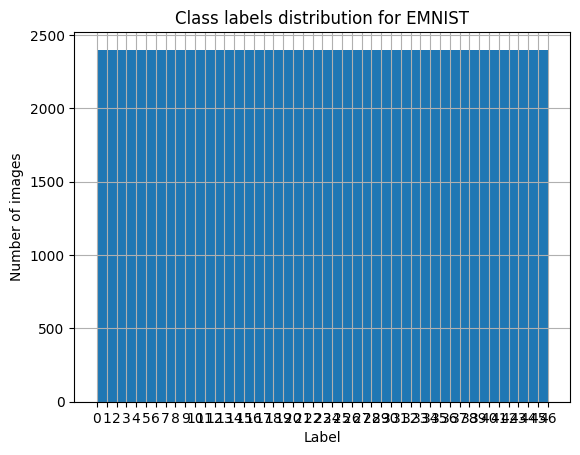

In [ ]:
# construct histogram
all_labels = trainset.targets
num_possible_labels = len(
    set(all_labels.numpy().tolist())
)  # this counts unique labels (so it should be with mnist = 10)
plt.hist(all_labels, bins=num_possible_labels)

# plot formatting
plt.xticks(range(num_possible_labels))
plt.grid()
plt.xlabel("Label")
plt.ylabel("Number of images")
plt.title("Class labels distribution for EMNIST")
print(all_labels)
print(len(set(all_labels.numpy().tolist())))

In [ ]:
# MID functions outside the model, as it is a "global"- Calculation for the parameters we put in
def calculate_MID(trainset):
    n_values = trainset.targets
    num_classes = len(set(all_labels.numpy().tolist())) # or just NUM_CLASSES
    N = sum(n_values)  # Total number of instances
    MID = 0.0

    for c in range(num_classes):
        n_c = torch.sum(n_values == c).item()  # Number of instances in class c
        MID += (n_c / N) * math.log(num_classes * n_c / N, num_classes)

    return MID

Let's visualise 32 images from the dataset


In [ ]:
def visualise_n_random_examples(trainset_, n: int, verbose: bool = True):
    # take n examples at random
    idx = list(range(len(trainset_.data)))
    random.shuffle(idx)
    idx = idx[:n]
    if verbose:
        print(f"will display images with idx: {idx}")

    # construct canvas
    num_cols = 8
    num_rows = int(np.ceil(len(idx) / num_cols))
    fig, axs = plt.subplots(figsize=(16, num_rows * 2), nrows=num_rows, ncols=num_cols)

    # display images on canvas
    for c_i, i in enumerate(idx):
        axs.flat[c_i].imshow(trainset_.data[i], cmap="gray")

will display images with idx: [81991, 83634, 46650, 13981, 34933, 3784, 4266, 11647, 74660, 14954, 71512, 100458, 32282, 101366, 26391, 96124, 24502, 34233, 96709, 1473, 105450, 9027, 15545, 73955, 94983, 111581, 28594, 27514, 45410, 4488, 27170, 13978]


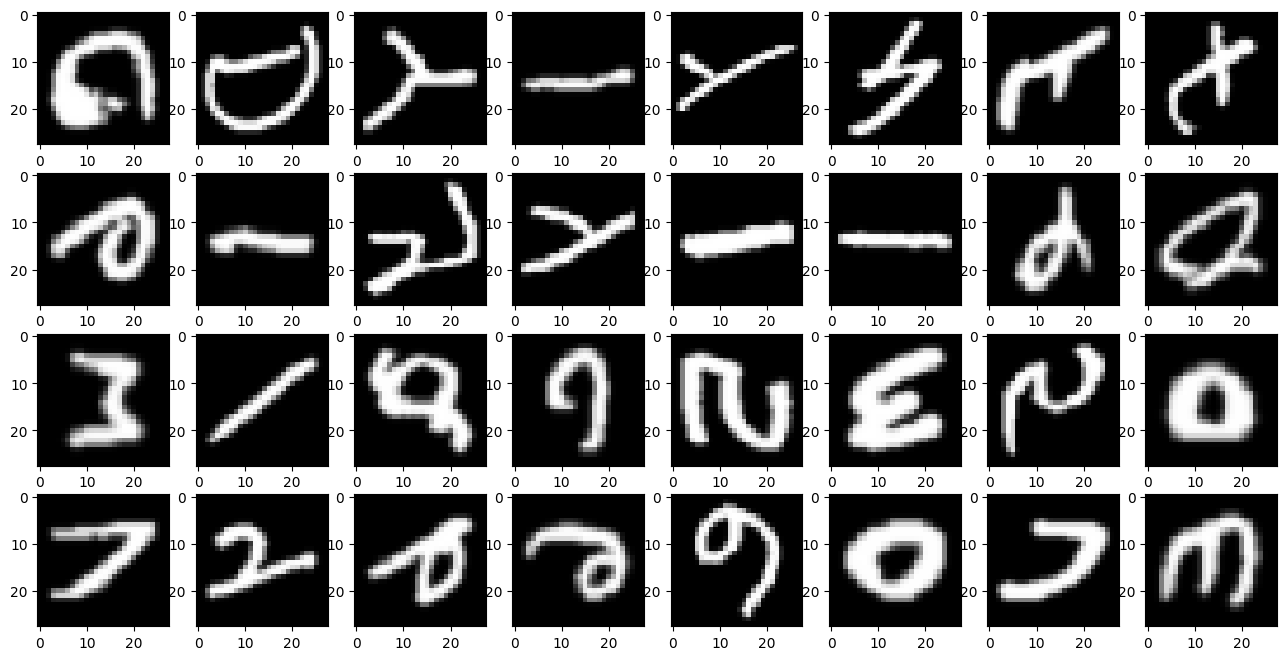

In [ ]:
visualise_n_random_examples(trainset, n=32)

### Centralized CNN Model Definition


Now that we have our dataset, we can construct a simple CNN model that will train on this dataset.



In [ ]:
# Define different types of CNN Models

class TutorialNet(nn.Module):
    def __init__(self, num_classes: int) -> None:
        super(TutorialNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class InterNet(nn.Module):
    def __init__(self, num_classes, fmaps1 = 40, fmaps2 = 160, dense = 200, dropout = 0.4):
        super(InterNet, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=fmaps1, kernel_size=5, stride=1, padding='same'),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=fmaps1, out_channels=fmaps2, kernel_size=5, stride=1, padding='same'),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fcon1 = nn.Sequential(nn.Linear(49*fmaps2, dense), nn.LeakyReLU())
        self.fcon2 = nn.Linear(dense, num_classes)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(self.fcon1(x))
        x = self.fcon2(x)
        return x

class ChatGPTNet(nn.Module):
    def __init__(self, num_classes):
        super(ChatGPTNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)  # Assuming 10 classes (digits 0-9)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

Similarly to what we did with the dataset you could inspect the model in various ways. We can, for instance, count the number of model parameters.

In [ ]:
model = TutorialNet(num_classes=47)
num_parameters = sum(value.numel() for value in model.state_dict().values())
print(f"{num_parameters = }")

num_parameters = 47571


## The Training Loops

We have defined three Baseline Models:
  - TutorialNet
  - InterNet: A basic non-optimized CNN implementation
  - ChatGPTNet: A optimized CNN to our dataset (courtesy of GitHub/austin-hill)
  
Its time to define and afterwards train the Models


In [ ]:
def train(net, trainloader, optimizer, epochs):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    net.train()
    for _ in range(epochs):
        for images, labels in trainloader:
            optimizer.zero_grad()
            loss = criterion(net(images), labels)
            loss.backward()
            optimizer.step()
    return net


def test(net, testloader):
    """Validate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, loss = 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
    accuracy = correct / len(testloader.dataset)
    return loss, accuracy


def run_centralised(epochs: int, lr: float, momentum: float = 0.9):
    """A minimal (but complete) training loop"""

    # instantiate the model
    model = TutorialNet(num_classes=47)

    # define optimiser with hyperparameters supplied
    optim = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    # get dataset and construct a dataloaders
    trainset, testset = get_mnist()
    trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)
    testloader = DataLoader(testset, batch_size=128)

    # train for the specified number of epochs
    trained_model = train(model, trainloader, optim, epochs)

    # training is completed, then evaluate model on the test set
    loss, accuracy = test(trained_model, testloader)
    print(f"{loss = }")
    print(f"{accuracy = }")

### Centralised Test Baseline EMNIST

In [ ]:
run_centralised(epochs=5, lr=0.01)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


loss = 62.34884126484394
accuracy = 0.8518617021276595


## Create the federated Dataset

To start designing a Federated Learning pipeline we need to meet one of the key properties in FL: each client has its own data partition. To accomplish this with the EMNIST dataset, we are going to generate N random partitions, where N is the total number of clients in our FL system.

In [ ]:
def prepare_dataset(num_partitions: int, batch_size: int, val_ratio: float = 0.1):
    """This function partitions the training set into N disjoint
    subsets, each will become the local dataset of a client. This
    function also subsequently partitions each traininset partition
    into train and validation. The test set is left intact and will
    be used by the central server to asses the performance of the
    global model."""

    # get the MNIST dataset
    trainset, testset = get_mnist()

    # split trainset into `num_partitions` trainsets
    num_images = len(trainset) // num_partitions

    partition_len = [num_images] * num_partitions

    trainsets = random_split(
        trainset, partition_len, torch.Generator().manual_seed(2023)
    )

    # create dataloaders with train+val support
    trainloaders = []
    valloaders = []
    for trainset_ in trainsets:
        num_total = len(trainset_)
        num_val = int(val_ratio * num_total)
        num_train = num_total - num_val

        for_train, for_val = random_split(
            trainset_, [num_train, num_val], torch.Generator().manual_seed(2023)
        )

        trainloaders.append(
            DataLoader(for_train, batch_size=batch_size, shuffle=True, num_workers=2)
        )
        valloaders.append(
            DataLoader(for_val, batch_size=batch_size, shuffle=False, num_workers=2)
        )

    # create dataloader for the test set
    testloader = DataLoader(testset, batch_size=128)

    return trainloaders, valloaders, testloader

Let's create 100 partitions and extract some statistics from one partition


number of images: 1016


Text(0.5, 1.0, 'Class labels distribution for EMNIST')

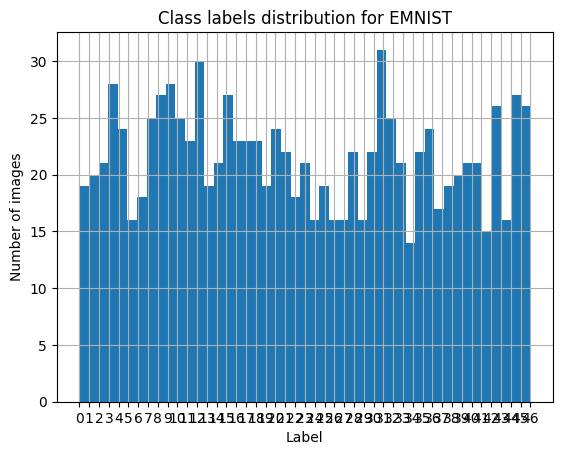

In [ ]:
trainloaders, valloaders, testloader = prepare_dataset(
    num_partitions=100, batch_size=64
)

# first partition
train_partition = trainloaders[0].dataset

# count data points
partition_indices = train_partition.indices
print(f"number of images: {len(partition_indices)}")

# visualise histogram
plt.hist(train_partition.dataset.dataset.targets[partition_indices], bins=47)
plt.grid()
plt.xticks(range(47))
plt.xlabel("Label")
plt.ylabel("Number of images")
plt.title("Class labels distribution for EMNIST")

## Defining a Flower Client

You can think of a client in FL as an entity that owns some data and trains a model using this data. The caveat is that the model is being trained _collaboratively_ in Federation by multiple clients (sometimes up to hundreds of thousands) and, in most instances of FL, is sent by a central server.

A Flower Client is a simple Python class with four distinct methods:

* `fit()`: With this method, the client does on-device training for a number of epochs using its own data. At the end, the resulting model is sent back to the server for aggregation.

* `evaluate()`: With this method, the server can evaluate the performance of the global model on the local validation set of a client. This can be used for instance when there is no centralised dataset on the server for validation/test. Also, this method can be use to asses the degree of personalisation of the model being federated.

* `set_parameters()`: This method takes the parameters sent by the server and uses them to initialise the parameters of the local model that is ML framework specific (e.g. TF, Pytorch, etc).

* `get_parameters()`: It extract the parameters from the local model and transforms them into a list of NumPy arrays. This ML framework-agnostic representation of the model will be sent to the server.


In [ ]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, trainloader, vallodaer) -> None:
        super().__init__()

        self.trainloader = trainloader
        self.valloader = vallodaer
        self.model = TutorialNet(num_classes=47)

    def set_parameters(self, parameters):
        """With the model parameters received from the server,
        overwrite the uninitialise model in this class with them."""

        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        # now replace the parameters
        self.model.load_state_dict(state_dict, strict=True)

    def get_parameters(self, config: Dict[str, Scalar]):
        """Extract all model parameters and convert them to a list of
        NumPy arrays. The server doesn't work with PyTorch/TF/etc."""
        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]

    def fit(self, parameters, config):
        """This method train the model using the parameters sent by the
        server on the dataset of this client. At then end, the parameters
        of the locally trained model are communicated back to the server"""

        # copy parameters sent by the server into client's local model
        self.set_parameters(parameters)

        # Define the optimizer -------------------------------------------------------------- Essentially the same as in the centralised example above
        optim = torch.optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)

        # do local training  -------------------------------------------------------------- Essentially the same as in the centralised example above (but now using the client's data instead of the whole dataset)
        train(self.model, self.trainloader, optim, epochs=1)

        # return the model parameters to the server as well as extra info (number of training examples in this case)
        return self.get_parameters({}), len(self.trainloader), {}

    def evaluate(self, parameters: NDArrays, config: Dict[str, Scalar]):
        """Evaluate the model sent by the server on this client's
        local validation set. Then return performance metrics."""

        self.set_parameters(parameters)
        loss, accuracy = test(
            self.model, self.valloader
        )  # <-------------------------- calls the `test` function, just what we did in the centralised setting (but this time using the client's local validation set)
        # send statistics back to the server

        return float(loss), len(self.valloader), {"accuracy": accuracy, "loss": loss}

In [ ]:
# MID functions outside the model, as it is a "global"- Calculation for the parameters we put in
def calculate_MID(global_distribution):
    global_distribution, local_distributions = get_distributions()
    N = sum(global_distribution)  # Total number of instances
    MID = 0.0
    for c in range(NUM_CLASSES):
        n_c = global_distribution[c]  # Number of instances in class c
        MID += (n_c / float(N)) * math.log(NUM_CLASSES * n_c / float(N), NUM_CLASSES)
    return MID

def calculate_WCS(global_distribution, local_distributions):
    # Calculate WCS
    local_sum = []
    g_norm_1 = torch.linalg.norm(global_distribution, dim=0, ord=1)
    g_norm_2 = torch.linalg.norm(global_distribution, dim=0, ord=2)

    for local_distribution in local_distributions:
        l_norm_1 = torch.linalg.norm(local_distribution, dim=0, ord=1)
        l_norm_2 = torch.linalg.norm(local_distribution, dim=0, ord=2)
        local_sum.append((l_norm_1/l_norm_2)*(global_distribution.float().dot(local_distribution)))

    # Mathematical definition of the WCS
    WCS = (g_norm_1/g_norm_2)*torch.stack(local_sum).sum(dim=0)

    return WCS

''' Probably unnecessary
# Define the WCS
# Compute local label distribution vector l_j
local_dataset = trainloader
local_trainset = local_dataset.targets # Described with according classes
num_classes = len(set(local_trainset.numpy().tolist())) # or just NUM_CLASSES
local_distribution = torch.zeros(num_classes)

for sample in local_trainset:
  label = local_trainset[sample]
  local_distribution[label] += 1
# Normalize the distribution
local_distribution /= len(local_trainset)
### RETURN STILL MISSING, DONT KNOW HOW TO PUT IT IN THERE WITH SENSE
'''

'''
# WCS (old)

def calculate_WCS1(local_distributions, global_distribution):
    # Convert input lists to numpy arrays
    local_distributions = np.array(local_distributions)
    global_distribution = np.array(global_distribution)

    # Calculate the total number of samples for each client
    k_li_1 = np.sum(local_distributions, axis=1)

    # Calculate the total number of samples for the global label distribution
    k_L_1 = np.sum(global_distribution)

    # Calculate the cosine similarity between L and each l_j
    cosine_similarities = np.dot(global_distribution, local_distributions.T) / (
        np.linalg.norm(global_distribution) * np.linalg.norm(local_distributions, axis=1)
    )

    # Calculate WCS
    WCS = np.sum(k_li_1 / k_L_1 * cosine_similarities)

    return WCS

# Example usage:
local_distributions = [[2, 0, 0], [0, 4, 0], [0, 0, 6]]
global_distribution = [2, 4, 6]

result = calculate_WCS(local_distributions, global_distribution)
print(f"WCS value: {result:.6f}")
'''

'\n# WCS (old)\n\ndef calculate_WCS1(local_distributions, global_distribution):\n    # Convert input lists to numpy arrays\n    local_distributions = np.array(local_distributions)\n    global_distribution = np.array(global_distribution)\n\n    # Calculate the total number of samples for each client\n    k_li_1 = np.sum(local_distributions, axis=1)\n\n    # Calculate the total number of samples for the global label distribution\n    k_L_1 = np.sum(global_distribution)\n\n    # Calculate the cosine similarity between L and each l_j\n    cosine_similarities = np.dot(global_distribution, local_distributions.T) / (\n        np.linalg.norm(global_distribution) * np.linalg.norm(local_distributions, axis=1)\n    )\n\n    # Calculate WCS\n    WCS = np.sum(k_li_1 / k_L_1 * cosine_similarities)\n\n    return WCS\n\n# Example usage:\nlocal_distributions = [[2, 0, 0], [0, 4, 0], [0, 0, 6]]\nglobal_distribution = [2, 4, 6]\n\nresult = calculate_WCS(local_distributions, global_distribution)\nprint(f"

 If we fuse the client's fit() and evaluate() methods, we'll end up with essentially the same as in the run_centralised() function we used in the Centralised.

## Construction of the Federated Model

Steps to run Federated Learning Algorithms:
1. Create the dataset partitions of the EMNIST dataset
2. Define the Client class
3. Define a strategy
4. Construct a final function, which is a space to spawn the virtual clients -> Create FlowerClient object, assigning each VC their own data partition

In [ ]:
### TODO: Change evaluate so that it returns 1: the global test set acc, and 2:
###       the federated validation acc

def get_evalulate_fn(testloader):
    """This is a function that returns a function. The returned
    function (i.e. `evaluate_fn`) will be executed by the strategy
    at the end of each round to evaluate the stat of the global
    model."""

    def evaluate_fn(server_round: int, parameters, config):
        """This function is executed by the strategy it will instantiate
        a model and replace its parameters with those from the global model.
        The model will be evaluated on the test set."""

        model = TutorialNet(num_classes=47)

        # set parameters to the model
        params_dict = zip(model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        model.load_state_dict(state_dict, strict=True)

        # call test
        loss, accuracy = test(
            model, testloader
        )  # <-------------------------- calls the `test` function, just what we did in the centralised setting
        return loss, {"accuracy": accuracy}

    return evaluate_fn


# now we can define the strategy
strategy = fl.server.strategy.FedAvg(
    fraction_fit=0.1,  # let's sample 10% of the client each round to do local training
    fraction_evaluate=0.2,  # after each round, let's sample 20% of the clients to asses how well the global model is doing
    min_available_clients=100,  # total number of clients available in the experiment
    evaluate_fn=get_evalulate_fn(testloader),
)  # a callback to a function that the strategy can execute to evaluate the state of the global model on a centralised dataset

Create a callback that the Simulation Engine will use to assign the different Virtual Clients. Create a client & assign each to their data partition

In [ ]:
def generate_client_fn(trainloaders, valloaders):
    def client_fn(cid: str):
        """Returns a FlowerClient containing the cid-th data partition"""

        return FlowerClient(
            trainloader=trainloaders[int(cid)], vallodaer=valloaders[int(cid)]
        ).to_client()

    return client_fn


client_fn_callback = generate_client_fn(trainloaders, valloaders)

**Launch** the experiment

In [ ]:
history = fl.simulation.start_simulation(
    client_fn=client_fn_callback,  # a callback to construct a client
    num_clients=100,  # total number of clients in the experiment
    config=fl.server.ServerConfig(num_rounds=3),  # let's run for 10 rounds
    strategy=strategy,  # the strategy that will orchestrate the whole FL pipeline
)

INFO flwr 2024-02-12 18:22:37,014 | app.py:178 | Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=3, round_timeout=None)
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-02-12 18:22:41,644	INFO worker.py:1621 -- Started a local Ray instance.
INFO flwr 2024-02-12 18:22:45,120 | app.py:213 | Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'object_store_memory': 3941912985.0, 'memory': 7883825972.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'CPU': 2.0, 'object_store_memory': 3941912985.0, 'memory': 7883825972.0}
INFO flwr 2024-02-12 18:22:45,130 | app.py:219 | Optimi

Below you can see how you can plot the centralised accuracy obtained at the end of each round (including at the very beginning of the experiment) for the _global model_.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive
history.metrics_centralized = {'accuracy': [(0, 0.020797872340425533), (1, 0.029361702127659574), (2, 0.03664893617021277), (3, 0.04824468085106383)]}


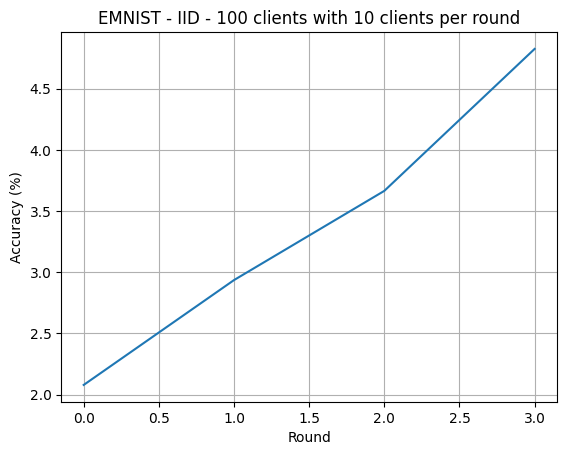

NameError: name 'get_distributions' is not defined

In [ ]:
drive.mount('/content/drive')

print(f"{history.metrics_centralized = }")

global_accuracy_centralised = history.metrics_centralized["accuracy"]

round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]
plt.plot(round, acc)
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.title("EMNIST - IID - 100 clients with 10 clients per round")
plt.savefig(f'/content/drive/My Drive/LAMA_ItW/Model_{np.random.randint(10000)}.png')
plt.show()

# MID Value
result = calculate_MID(trainset)
print(f"MID value: {result:.6f}")